#Table of Contents
* [Walltime](#Walltime)
* [Speedup](#Speedup)
* [Memory consumption](#Memory-consumption)
* [Exact counting](#Exact-counting)
	* [Table](#Table)
* [Streaming](#Streaming)
* [Summaries description](#Summaries-description)
	* [Reads stats](#Reads-stats)
	* [Walltime stats](#Walltime-stats)
	* [Memory stats](#Memory-stats)


In [187]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#sns.set_style('ticks')
sns.set_style('whitegrid')

# Walltime

In [188]:
%run ../scripts/bench_to_csv.py
%run ../scripts/plot_functions.py

In [189]:
summary_io = parse_exp('just-io', REPLICATES, dir='../benchmarks')
summary_hll = parse_exp('unique-kmers', REPLICATES, threads=THREADS, dir='../benchmarks')
summary_kmerstream = parse_exp('kmerstream', REPLICATES, threads=THREADS, dir='../benchmarks')

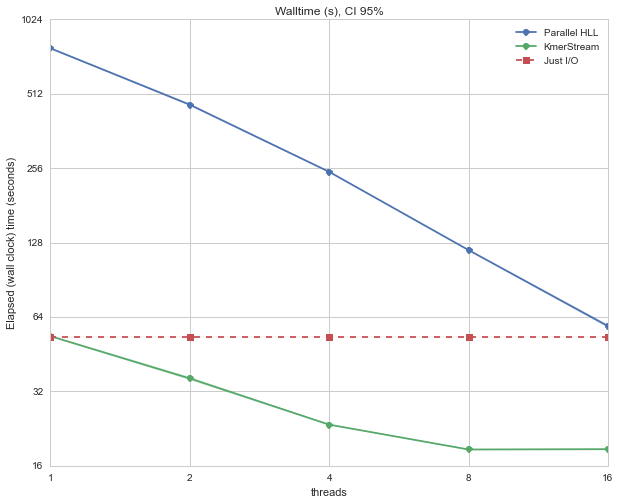

In [195]:
plot_data_walltime = prepare_plot_data(summary_io, summary_hll, summary_kmerstream, 'Elapsed (wall clock) time (seconds)')
fig = tsplot(plot_data_walltime, "Elapsed (wall clock) time (seconds)")
ax = fig.gca()
ax.set_ylim()#bottom=1)
ax.set_title("Walltime (s), CI 95%")
fig.savefig('../manuscript/figures/io_bound_walltime.pdf')

# Speedup

In [191]:
speedup_base_hll = (plot_data_walltime
  [(plot_data_walltime["threads"] == 1) & (plot_data_walltime["condition"] == "Parallel HLL")]
  ["Elapsed (wall clock) time (seconds)"]
  .median())

speedup_base_io = (plot_data_walltime
  [(plot_data_walltime["threads"] == 1) & (plot_data_walltime["condition"] == "Just I/O")]
  ["Elapsed (wall clock) time (seconds)"]
  .median())

speedup_base_kmerstream = (plot_data_walltime
  [(plot_data_walltime["threads"] == 1) & (plot_data_walltime["condition"] == "KmerStream")]
  ["Elapsed (wall clock) time (seconds)"]
  .median())

In [181]:
plot_data_walltime['speedup'] = speedup_base_hll / plot_data_walltime["Elapsed (wall clock) time (seconds)"]

plot_data_walltime.loc[(plot_data_walltime['condition'] == "Just I/O", "speedup")] = (
    speedup_base_io / 
    plot_data_walltime.loc[(plot_data_walltime['condition'] == "Just I/O")]
      ["Elapsed (wall clock) time (seconds)"])

plot_data_walltime.loc[(plot_data_walltime['condition'] == "KmerStream", "speedup")] = (
    speedup_base_kmerstream / 
    plot_data_walltime.loc[(plot_data_walltime['condition'] == "KmerStream")]
      ["Elapsed (wall clock) time (seconds)"])

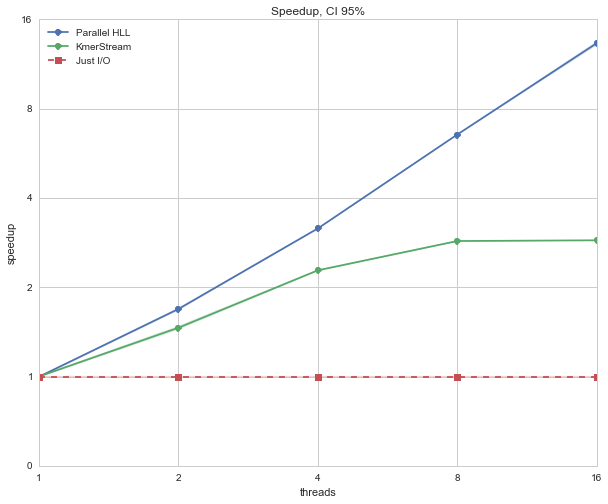

In [183]:
fig = tsplot(plot_data_walltime, "speedup")
ax = fig.gca()
ax.set_title("Speedup, CI 95%")
fig.savefig('../manuscript/figures/io_bound_speedup.pdf')

# Memory consumption

In [184]:
plot_data_mem = prepare_plot_data(summary_io, summary_hll, summary_kmerstream, 'Maximum resident set size (kbytes)')

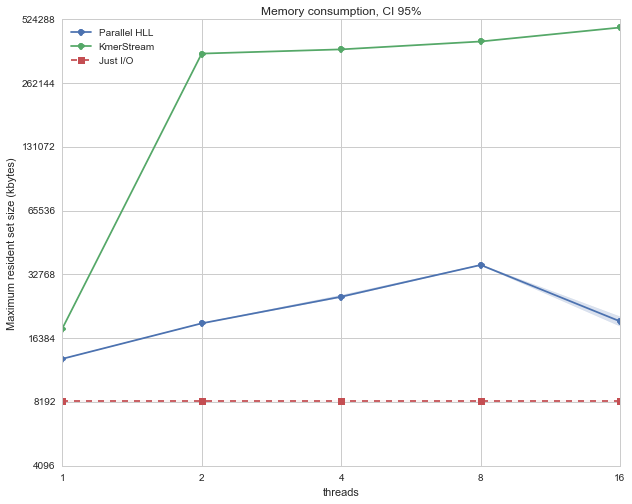

In [185]:
fig = tsplot(plot_data_mem, "Maximum resident set size (kbytes)")
ax = fig.gca()
ax.set_title("Memory consumption, CI 95%")
ax.set_ylim(bottom=4096)
fig.savefig('../manuscript/figures/mem_consumption.pdf')

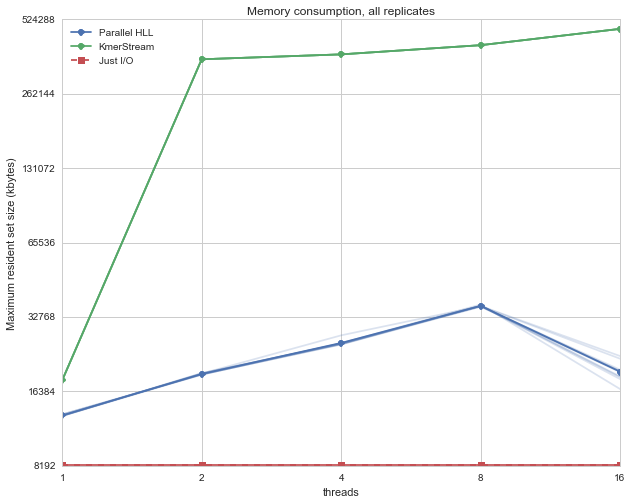

In [186]:
fig = tsplot(plot_data_mem, "Maximum resident set size (kbytes)", unit_traces=True)
ax = fig.gca()
ax.set_title("Memory consumption, all replicates")
fig.savefig('../manuscript/figures/mem_consumption_unit_traces.pdf')

# Exact counting

In [145]:
summaries = {}
n_unique_kmers = {}

n_unique_kmers['small'] = {
  'py': 670487,
  'sparsehash': 670487,
  'hll': 670328
}

n_unique_kmers['medium'] = {
  'py': 17510301,
  'sparsehash': 17510301,
  'hll': 17686322
}

summaries['small'] = {
  'py':         parse_exp('exact-py-small', REPLICATES, dir='../benchmarks'),
  'sparsehash': parse_exp('exact-sparsehash-small', range(1, 11), dir='../benchmarks'),
  'hll':        parse_exp('hll-small', REPLICATES, dir='../benchmarks')
}
    
summaries['medium'] = {
  'py':         parse_exp('exact-py-medium', REPLICATES, threads=THREADS, dir='../benchmarks'),
  'sparsehash': parse_exp('exact-sparsehash-medium', range(1, 11), threads=THREADS, dir='../benchmarks'),
  'hll':        parse_exp('hll-medium', REPLICATES, threads=THREADS, dir='../benchmarks')
}

In [97]:
dfs = {}
for size in ('small', 'medium'):
    df = pd.DataFrame()
    for src, summary in summaries[size].items():
        sr = summary[['Maximum resident set size (kbytes)', 'Elapsed (wall clock) time (seconds)']].mean()
        sr['implementation'] = src
        sr['cardinality'] = n_unique_kmers[size][src]
        df = df.append(sr, ignore_index=True)
    exact =  df[df['implementation'] == 'sparsehash']['cardinality'].values[0]
    df['error (%)'] = abs((df['cardinality'] - exact) / exact) * 100
    dfs[size] = df.set_index('implementation')

## Tables

In [99]:
dfs['small'].sort('Elapsed (wall clock) time (seconds)')

,Elapsed (wall clock) time (seconds),Maximum resident set size (kbytes),cardinality,error (%)
implementation,,,,
hll,0.193,13439.6,670328,0.023714
sparsehash,3.888,77636.0,670487,0.000000
py,4.306,83476.4,670487,0.000000


In [100]:
print(dfs['small'].sort('Elapsed (wall clock) time (seconds)').to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Elapsed (wall clock) time (seconds) &  Maximum resident set size (kbytes) &  cardinality &  error (\%) \\
\midrule
implementation &                                      &                                     &              &            \\
hll            &                                0.193 &                             13439.6 &       670328 &   0.023714 \\
sparsehash     &                                3.888 &                             77636.0 &       670487 &   0.000000 \\
py             &                                4.306 &                             83476.4 &       670487 &   0.000000 \\
\bottomrule
\end{tabular}



In [101]:
dfs['medium'].sort('Elapsed (wall clock) time (seconds)')

,Elapsed (wall clock) time (seconds),Maximum resident set size (kbytes),cardinality,error (%)
implementation,,,,
hll,12.080,13376.4,17686322,1.005243
sparsehash,344.041,2018502.4,17510301,0.000000
py,891.171,2056048.0,17510301,0.000000


In [102]:
print(dfs['medium'].sort('Elapsed (wall clock) time (seconds)').to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Elapsed (wall clock) time (seconds) &  Maximum resident set size (kbytes) &  cardinality &  error (\%) \\
\midrule
implementation &                                      &                                     &              &            \\
hll            &                               12.080 &                             13376.4 &     17686322 &   1.005243 \\
sparsehash     &                              344.041 &                           2018502.4 &     17510301 &   0.000000 \\
py             &                              891.171 &                           2056048.0 &     17510301 &   0.000000 \\
\bottomrule
\end{tabular}



# Streaming

In [49]:
streaming_io = parse_exp('streaming_just-io', REPLICATES, dir='../benchmarks')
streaming_hll = parse_exp('streaming_unique-kmers', REPLICATES, threads=THREADS, dir='../benchmarks')

In [50]:
streaming_io['Elapsed (wall clock) time (seconds)'].describe()

count     10.000000
mean     199.479000
std       13.565966
min      185.500000
25%      192.527500
50%      194.765000
75%      201.470000
max      234.100000
Name: Elapsed (wall clock) time (seconds), dtype: float64

In [52]:
streaming_hll[streaming_hll["threads"] == 1]['Elapsed (wall clock) time (seconds)'].describe()

count     10.000000
mean     199.721000
std        9.458836
min      188.110000
25%      194.350000
50%      198.895000
75%      200.410000
max      222.490000
Name: Elapsed (wall clock) time (seconds), dtype: float64

In [53]:
streaming_hll[streaming_hll["threads"] != 1]['Elapsed (wall clock) time (seconds)'].describe()

count     40.00000
mean     203.13550
std       16.99295
min      184.28000
25%      191.86750
50%      197.71000
75%      207.47500
max      261.89000
Name: Elapsed (wall clock) time (seconds), dtype: float64

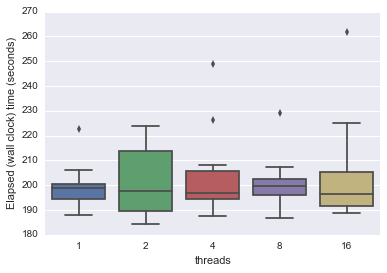

In [59]:
ax = sns.boxplot(x="threads", y="Elapsed (wall clock) time (seconds)", data=streaming_hll)

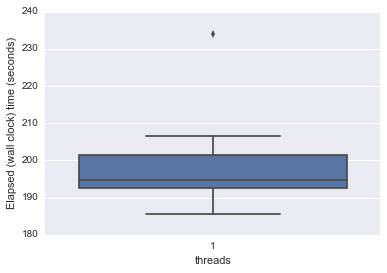

In [57]:
ax = sns.boxplot(x="threads", y="Elapsed (wall clock) time (seconds)", data=streaming_io)

# Summaries description

## Reads stats

In [14]:
for i in ("SRR797943.fastq", "SRR1216679_1.fastq", "SRR1304364_1.fastq"):
    stats = !readstats.py ../inputs/$i
    print(stats[-1])

704951 bp / 417 seqs; 1690.5 average length -- total
168809000 bp / 675236 seqs; 250.0 average length -- total
2113086496 bp / 163379 seqs; 12933.6 average length -- total


## Walltime stats

In [15]:
summary_io['Elapsed (wall clock) time (seconds)'].describe()

count    10.00000
mean     53.20500
std       0.03504
min      53.14000
25%      53.19000
50%      53.20000
75%      53.23750
max      53.25000
Name: Elapsed (wall clock) time (seconds), dtype: float64

In [16]:
(summary_hll[['Elapsed (wall clock) time (seconds)', 'threads']]
   .groupby('threads')
   .describe())

Elapsed (wall clock) time (seconds)
threads                                           
1       count                            10.000000
        mean                            783.175000
        std                               7.440867
        min                             777.420000
        25%                             777.810000
        50%                             781.220000
        75%                             785.412500
        max                             801.540000
2       count                            10.000000
        mean                            462.788000
        std                               6.826403
        min                             452.340000
        25%                             460.175000
        50%                             462.035000
        75%                             462.697500
        max                             479.120000
4       count                            10.000000
        mean                            247.529000
        std                               1.733150
        min                             244.760000
        25%                             246.460000
        50%                             247.680000
        75%                             248.945000
        max                             249.720000
8       count                            10.000000
        mean                            119.351000
        std                               0.593623
        min                             118.540000
        25%                             118.910000
        50%                             119.260000
        75%                             119.732500
        max                             120.400000
16      count                            10.000000
        mean                             58.731000
        std                               1.391518
        min                              57.290000
        25%                              57.625000
        50%                              58.445000
        75%                              59.162500
        max                              61.340000

## Memory stats

In [17]:
summary_io['Maximum resident set size (kbytes)'].describe()

count      10.000000
mean     8244.400000
std         2.951459
min      8240.000000
25%      8244.000000
50%      8244.000000
75%      8247.000000
max      8248.000000
Name: Maximum resident set size (kbytes), dtype: float64

In [18]:
(summary_hll[['Maximum resident set size (kbytes)', 'threads']]
   .groupby('threads')
   .describe())

Maximum resident set size (kbytes)
threads                                          
1       count                           10.000000
        mean                         13095.600000
        std                             84.294721
        min                          13020.000000
        25%                          13034.000000
        50%                          13060.000000
        75%                          13178.000000
        max                          13216.000000
2       count                           10.000000
        mean                         19267.200000
        std                            105.507030
        min                          19124.000000
        25%                          19183.000000
        50%                          19248.000000
        75%                          19338.000000
        max                          19420.000000
4       count                           10.000000
        mean                         25734.400000
        std                            671.577116
        min                          25360.000000
        25%                          25472.000000
        50%                          25536.000000
        75%                          25642.000000
        max                          27624.000000
8       count                           10.000000
        mean                         36335.200000
        std                            208.134999
        min                          36092.000000
        25%                          36200.000000
        50%                          36328.000000
        75%                          36413.000000
        max                          36804.000000
16      count                           10.000000
        mean                         19676.800000
        std                           1768.753786
        min                          16736.000000
        25%                          18733.000000
        50%                          19672.000000
        75%                          19977.000000
        max                          22764.000000